In [1]:
from functools import partial
import os, sys
import numpy as np
from numpy import log, exp, sqrt
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *
from src.model import Environment, Agent

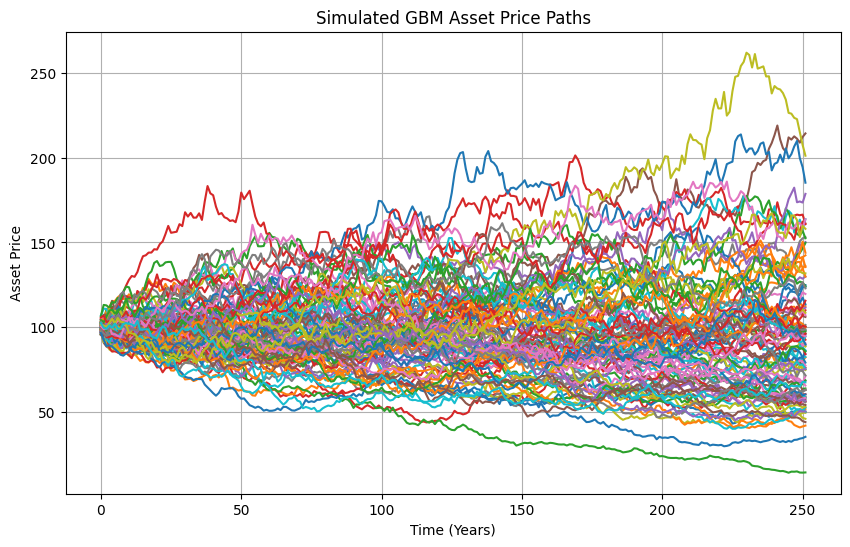

In [2]:
nsim = 100          
nstep = 252       
t1 = 0            
t2 = 1.0          
s_0 = 100        
r = 0.01         
q = 0.0          
v = 0.4          

price_paths = generate_gbm_paths(nsim, nstep, t1, t2, s_0, r, q, v)
#price_paths = generate_heston_paths(nsim, nstep, t1, t2, s_0, r, q, v, theta, rho, kappa, sigma, **kwargs)

plt.figure(figsize=(10, 6))
plt.plot(price_paths.T)
plt.title('Simulated GBM Asset Price Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()



In [3]:
K = 100 
price_paths = generate_gbm_paths(nsim=1000, nstep=252, t1=0, t2=1.0, s_0=100, r=0.04, q=0, v=0.4)
env = Environment(price_paths=price_paths, K=K, t1=0, t2=1.0, r=0.04, option_type="put")

obs = env.reset()
print(f"Initial Observation: {obs}")

done = False
step_count = 0

while not done:
    action = env.action_space.sample() 
    obs, reward, done, info = env.step(action)
    step_count += 1
    print(f"Step {step_count}: Obs={obs}, Reward={reward}, Done={done}, Info={info}")


Initial Observation: [99.00694     1.          0.99006945]
Step 1: Obs=[101.8367       0.99603176   1.0183669 ], Reward=0, Done=False, Info={'intrinsic_value': 0.0}
Step 2: Obs=[101.8367       0.99603176   1.0183669 ], Reward=0.0, Done=True, Info={'intrinsic_value': 0.0}


In [4]:
agent = Agent(obssize=3, actsize=2, hidden_dim=64, depth=2, lr=1e-3, buffer_size=10000, batch_size=64, gamma=0.99, eps=1.0)
agent.initialize_buffer(env, steps=5000)  

In [ ]:
def train(agent, env, episodes, update_target_every, moving_avg_window=50):
    """
    Train the agent and visualize training progress.
    """
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.buffer.add(state, action, reward, next_state, done)

            agent.learn()
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        # Update the target network periodically
        if episode % update_target_every == 0:
            agent.update_params()

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {total_reward}, Average Reward: {np.mean(rewards)}, Eps: {agent.eps:.3f}")

        agent.eps = max(agent.eps * 0.99, 0.01)  # Eps decay 

    moving_avg_rewards = np.convolve(rewards, np.ones(moving_avg_window) / moving_avg_window, mode='valid')
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label="Total Reward per Episode", alpha=0.4)
    plt.plot(
        range(moving_avg_window - 1, len(rewards)),
        moving_avg_rewards,
        label=f"Moving Average Reward (window={moving_avg_window})",
        color='red'
    )
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress with Moving Average")
    plt.legend()
    plt.grid(True)
    plt.show()

    return rewards

/Users/GuidoDeFilippo/Columbia/Reinforcement Learning/orcs-4529-rl/notebooks/../src/model.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return [torch.tensor(x, dtype=torch.float32) for x in zip(*batch)]


Episode 0/5000, Total Reward: 0.0, Epsilon: 1.000
Episode 100/5000, Total Reward: 0.0, Epsilon: 0.366
Episode 200/5000, Total Reward: 0.14053807910256577, Epsilon: 0.134
Episode 300/5000, Total Reward: 0.993343454000443, Epsilon: 0.049
Episode 400/5000, Total Reward: 0.0, Epsilon: 0.018
Episode 500/5000, Total Reward: 0.0, Epsilon: 0.010
Episode 600/5000, Total Reward: 4.246892625621571, Epsilon: 0.010
Episode 700/5000, Total Reward: 9.19179707765447, Epsilon: 0.010
Episode 800/5000, Total Reward: 0.0, Epsilon: 0.010
Episode 900/5000, Total Reward: 14.574442075566976, Epsilon: 0.010
Episode 1000/5000, Total Reward: 10.34060257900421, Epsilon: 0.010
Episode 1100/5000, Total Reward: 0.0, Epsilon: 0.010
Episode 1200/5000, Total Reward: 8.213330935274364, Epsilon: 0.010
Episode 1300/5000, Total Reward: 11.121891162735574, Epsilon: 0.010
Episode 1400/5000, Total Reward: 12.133339540003677, Epsilon: 0.010
Episode 1500/5000, Total Reward: 11.404952854621142, Epsilon: 0.010
Episode 1600/5000, 

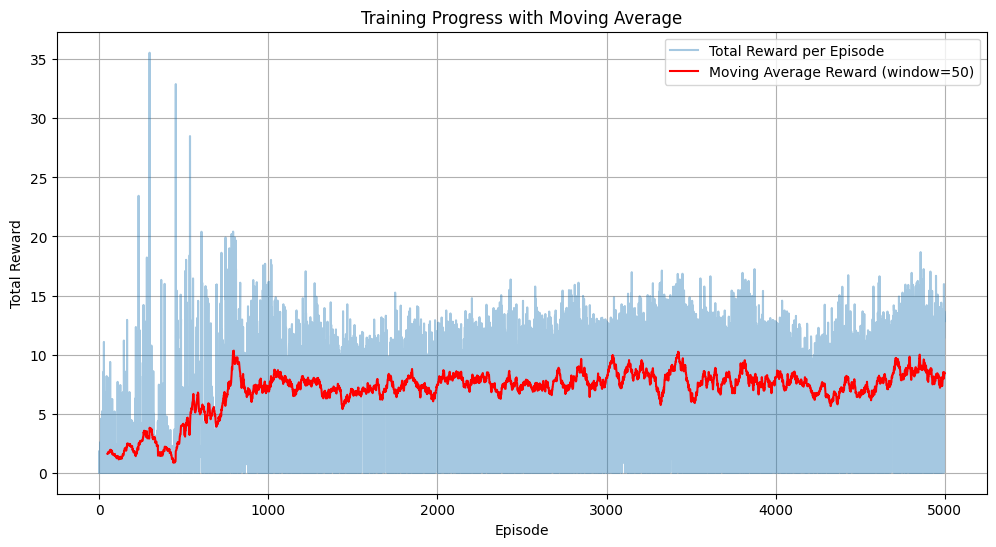

In [6]:
# Train the agent
episodes = 5000
update_target_every = 10
rewards = train(agent, env, episodes, update_target_every)

In [7]:
np.mean(rewards[1000:])

7.654308727179168

In [8]:
def plot_exercise_boundary(agent, env, n_paths=100, strike_price=150):
    """
    Visualize the early exercise boundary for a sample of paths.
    """
    plt.figure(figsize=(12, 8))
    exercise_points = []

    for i in range(n_paths):
        state = env.reset()
        path = [state[0]]  
        times = [0]  
        done = False

        while not done:
            # Select an action using a greedy policy
            action = agent.act(state)

            if action == 1:  # Exercise
                exercise_points.append((env.current_step * env.dt, state[0]))  # Record exercise point
                done = True
            else:
                env.current_step += 1
                if env.current_step >= env.nstep:  # Check if the path has ended
                    done = True
                else:
                    # Construct the next state manually
                    next_price = env.price_paths[env.curr_path, env.current_step]
                    remaining_time = env.t2 - env.current_step * env.dt
                    intrinsic_value = env.intrinsic_value(next_price)
                    state = np.array([next_price, remaining_time, intrinsic_value])
                    path.append(next_price)
                    times.append(env.current_step * env.dt)

        # Plot the asset price path
        plt.plot(times, path, color='blue', alpha=0.3)

    if exercise_points:
        ex_times, ex_prices = zip(*exercise_points)
        plt.scatter(ex_times, ex_prices, color='red', label='Exercise Points')

    # strike price for reference
    plt.axhline(y=strike_price, color='green', linestyle='--', label='Strike Price')

    plt.title(f"Early Exercise Boundary Visualization ({n_paths} Paths)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.grid(True)
    plt.show()

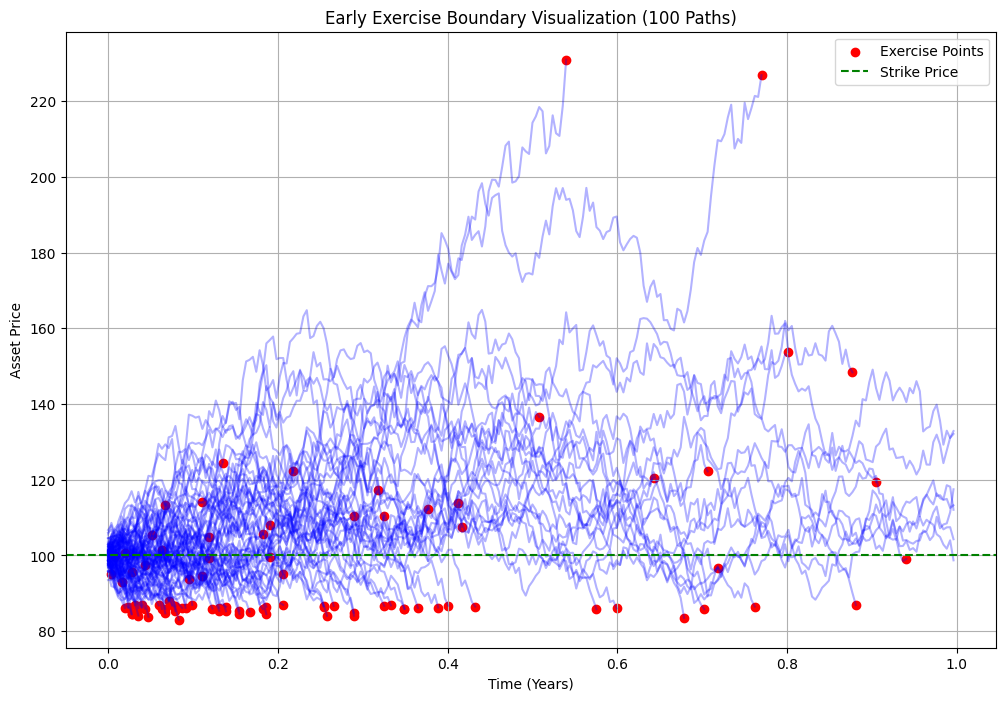

In [9]:
plot_exercise_boundary(agent, env, n_paths=100, strike_price=K)

In [10]:
def estimate_option_price(agent, env, n_paths=10000):
    """
    Estimate the option price using the trained agent.
    """
    total_rewards = []

    for _ in range(n_paths):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    # Return the average reward as the estimated price
    return np.mean(total_rewards)

In [11]:
estimate_option_price(agent, env, n_paths = 500)

7.728704121249999